# Введение в анализ данных

## Марковские цепи

В этом ноутбуке мы рассмотрим марковские цепи – вероятностные модели, описывающие последовательности случайных величин, для которых каждая следующая случайная величина непосредственно зависит только от текущей случайной величины, а не от всех предыдущих случайных величин (свойство Маркова). Практическую интерпретацию теории вероятности мы обсуждали на лекции.

In [14]:
from collections import Counter, defaultdict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import ngrams, word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

nltk.download('punkt_tab')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

sns.set(style="darkgrid", palette="Set2")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 1. Определение и примеры

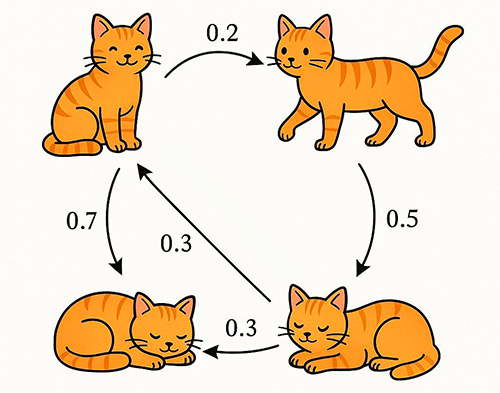

#### 1.1 Определение

>Марковской цепью на множестве состояний $\mathscr{X}$ называется последовательность случайных величин $(X_0, X_1, X_2, \ldots )$, где случайная величина $X_t$ соответствует состоянию в цепи в момент времени $t$, а также выполняется свойство Маркова:
> * для всех $t \geq 0$ и всех $s_0, s_1, \ldots, s_t, s_{t+1} \in \mathscr{X}$ выполняется следующий условный переход:
>
> $$ \mathsf{P}\left(X_{t+1} = s_{t+1} \ \left|\ X_t = s_{t}, X_{t-1} = s_{t-1}, \ldots, X_0 = s_{0} \right.\right) = \mathsf{P}\left(X_{t+1} = s_{t+1} \ \left|\ X_t = s_{t}\right.\right);$$
>
> * иначе говоря, вероятность нахождения в следующем состоянии **зависит только от текущего состояния**, а не от последовательности предыдущих состояний.
>
> **Ключевая особенность**\
В отличие от последовательностей независимых случайных величин, в марковской цепи все величины зависимы.


Марковские цепи могут быть полезны в различных областях:

- **Теория вероятностей и статистика**: для моделирования и анализа стохастических процессов.
- **Экономика и финансы**: для описания и прогнозирования изменений на рынках.
- **Биология и экология**: для моделирования популяционных динамик и взаимодействия видов.
- **NLP**: для обработки естественного языка.


#### 1.2 Моделирование погоды

Рассмотрим искусственный процесс для моделирования погоды.


**Состояния**:

- ☔️ дождь
- ☁️ облачно
- ☀️ солнечно

**Предполагается, что**:

- Если сейчас идёт дождь, то с вероятностью 60% завтра будет облачно, а с вероятностью 20% — солнечно.
- Если сейчас облачно, то на следующий день с вероятностью 40% сохранится облачность, с вероятностью 30% начнётся дождь, и ещё с такой же вероятностью будет солнечно.
- Если сегодня солнечно, то с вероятностью 80% погода останется ясной, а с вероятностью 10% будет облачно.

Эту информацию можно представить в виде матрицы переходных вероятностей:

|   | дождь | облачно | солнечно |
|---|-----------|-------------|--------------|
| **дождь** | 0.2       | 0.6         | 0.2          |
| **облачно** | 0.3       | 0.4         | 0.3          |
| **солнечно** | 0.1       | 0.1         | 0.8          |

В этой матрице:

- Строки представляют текущее состояние (то, как было);
- Столбцы представляют будущее состояние (то, как стало).

Матрица переходов $P$ описывает, как вероятности состояния системы распределяются на следующий шаг времени. Это квадратная матрица размерности $k \times k$, где $P \in \mathbb{R}^{k \times k}$. Каждая строка этой матрицы суммируется до 1 и описывает полную вероятность перехода из одного состояния в другие.



>В общем случае, если вероятности переходов не меняются с течением времени, цепь с конечным числом состояний $S = \{s_1, s_2, \ldots, s_k\}$ можно задать:
>
> * **Начальным распределением** $\pi \in \mathbb{R}^k$, где
>   * $\pi_i = \mathsf{P}(X_0 = s_i)$,
>   * $\sum\limits_{i=1}^{k} \pi_i = 1$;
>
> * **Матрицей переходов $P \in \mathbb{R}^{k\times k}$**, где
>   * $P_{ij} = \mathsf{P}(X_{t+1} = s_j \mid X_t = s_i)$,
>   * $\sum\limits_{j=1}^{k} P_{ij} = 1$ для всех $i$.
>


---



Сгенерируем несколько последовательностей погоды, которые будут соответствовать матрице перехода и сравним их с последовательностями, в которых все состояния независимы.

Зададим две функции для генерации цепей состояний:

In [15]:
def generate_markov_chain(trans_matrix: list[list[float]],
                         start_state: str,
                         size: int,
                         state_codes: Dict[str, int],
                         states: List[str]) -> List[str]:
    """
    Генерирует последовательность состояний цепи Маркова заданной длины.

    Параметры:
    ----------
    trans_matrix : np.ndarray
        Матрица переходных вероятностей (размер N x N, где N - количество состояний)
    start_state : str
        Начальное состояние цепи
    size : int
        Длина генерируемой последовательности
    state_codes : Dict[str, int]
        Словарь соответствия состояний и их индексов в матрице
    states : List[str]
        Список всех возможных состояний

    Возвращает:
    -----------
    List[str]
        Сгенерированная последовательность состояний
    """
    chain = [start_state]
    for _ in range(size - 1):
        current_state_idx = state_codes[chain[-1]]
        next_state_probs = trans_matrix[current_state_idx]
        next_state = np.random.choice(states, p=next_state_probs)
        chain.append(next_state)
    return chain

def generate_independent_chain(probs: list[float],
                              size: int,
                              states: List[str]) -> List[str]:
    """
    Генерирует последовательность независимых состояний заданной длины.

    Параметры:
    ----------
    probs : np.ndarray
        Вероятности каждого состояния (должны суммироваться к 1)
    size : int
        Длина генерируемой последовательности
    states : List[str]
        Список всех возможных состояний

    Возвращает:
    -----------
    List[str]
        Сгенерированная последовательность состояний
    """
    return np.random.choice(states, size=size, p=probs).tolist()

Определим используемые параметры для моделирования погодной системы на основе предложенных данных:

In [16]:
# Параметры
states = ['дождь', 'облачно', 'солнечно']
state_codes = {'дождь': 0, 'облачно': 1, 'солнечно': 2}
n_days = 21

# Матрица переходов
transition = [
    [0.2, 0.6, 0.2],  # дождь
    [0.3, 0.4, 0.3],  # облачно
    [0.1, 0.1, 0.8]   # солнечно
]

# Вероятности событий для независимой генерации
stationary_probs = [0.18, 0.26, 0.56]

# Список событий
states = ['дождь', 'облачно', 'солнечно']
state_codes = {'дождь': 0, 'облачно': 1, 'солнечно': 2}

Получим несколько траекторий:

In [17]:
# Генерация цепей состояний Маркова для каждого возможного начального состояния
chains = [generate_markov_chain(transition,
                                start_state,
                                n_days,
                                state_codes,
                                states) for start_state in states]

# Конвертация состояний в числовые коды для каждой сгенерированной цепи
codes = [[state_codes[s] for s in chain] for chain in chains]

# Генерация независимых последовательностей состояний с распределением по stationary_probs
chains_independent = [generate_independent_chain(stationary_probs,
                                                 n_days,
                                                 states) for i in range(3)]

# Конвертация независимых состояний в числовые коды
codes_independent = [[state_codes[s] for s in chain] for chain in chains_independent]

Визуализируем эти траектории:

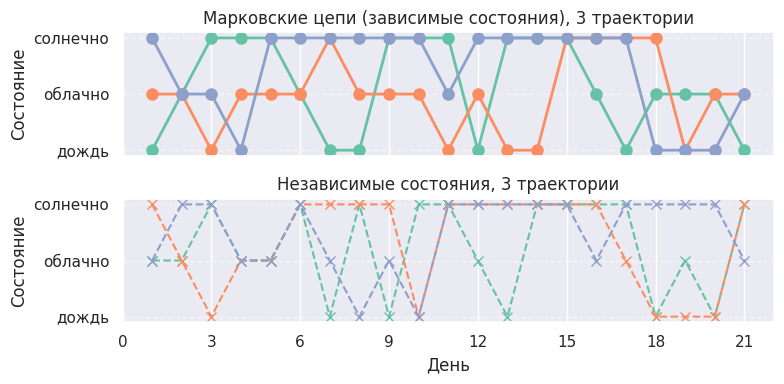

In [18]:
# Генерация графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

for i, start_state in enumerate(states):
    chain = chains[i]
    code = codes[i]
    ax1.plot(range(1, n_days + 1), code, 'o-',
             linewidth=2,
             markersize=8)

for i in range(3):
    chain = chains_independent[i]
    code = codes_independent[i]
    ax2.plot(range(1, n_days + 1), code, 'x--',
             linewidth=1.5,
             markersize=7)

# Настройка первого графика
ax1.set_title('Марковские цепи (зависимые состояния), 3 траектории')
ax1.set_ylabel('Состояние')
ax1.set_yticks([0, 1, 2])
ax1.set_yticklabels(states)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Настройка второго графика
ax2.set_title('Независимые состояния, 3 траектории')
ax2.set_xlabel('День')
ax2.set_ylabel('Состояние')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(states)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Обновляем настройки оси X для целочисленного отображения дней
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Можно заметить, что в случае марковских цепей из дождливой погоды самый частотный переход именно в облачную, в то время как для независимой генерации мы скорее перейдем в солнечную погоду, так как она наиболее веротяна в этой модели.
Поэтому для моделирования зависимых последовательных данных может быть недостаточно модели, где все элементы независимы.

#### 1.3 Google PageRank

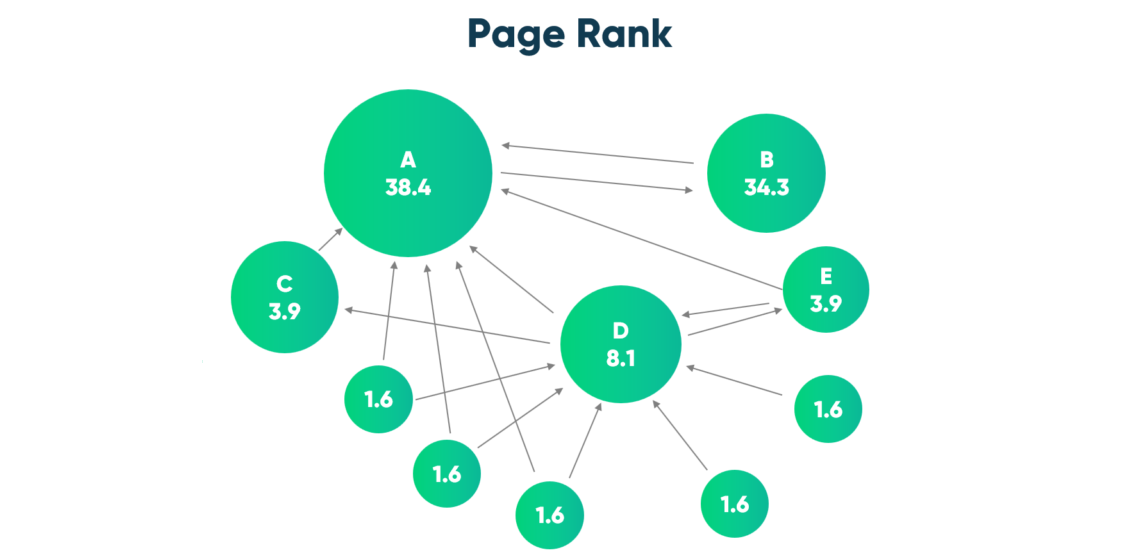

Google PageRank — это один из ранних алгоритмов, разработанных для ранжирования веб-страниц в результатах поиска. Алгоритм был предложен Ларри Пейджем и Сергеем Брином в 1996 году. Интересно, что PageRank оценивает "важность" веб-страницы по числу и качеству ссылок на нее, используя концепцию случайных блужданий, которая основана на марковской цепи.

**Как это работает:**

1. Граф ссылок: Веб можно представить как граф, где страницы — это вершины, а ссылки между ними — это направленные ребра.

2. Случайное блуждание: Представьте себе случайного пользователя, который переходит по страницам, следуя ссылкам на них. PageRank моделирует такое поведение как марковскую цепь.

3. Марковская цепь:
   - Состояния: Веб страницы.
   - Матрица переходов: Элемент матрицы – вероятность перехода с одной страницы на другую через ссылку. Основное предположение в модели PageRank — случайный пользователь с вероятностью $ p $ использует предоставленную ссылку, а с вероятностью $ (1-p) $ переходит на случайную страницу.

4. Распределение: В конечном итоге, PageRank вычисляет вероятности того, что этот пользователь окажется на той или иной странице, что и является значением PageRank для страницы.


### 2. Генерация текста с помощью марковских цепей

Теперь посмотрим на реальном примере, как с помощью марковских цепей можно генерировать текстовые данные.

N-граммные модели и их применения, такие как марковские цепи и скрытые марковские модели (HMM), были особенно популярны с конца 1980-х до начала 2010-х годов. В этот период они активно использовались в задачах обработки естественного языка:

* **Обработка и генерация текста**: Марковские цепи использовались для моделирования языковых последовательностей и предсказания вероятности следующего слова в тексте, основываясь на предыдущих словах.

* **Определение частей речи (POS tagging):** В ранних системах для автоматического определения частей речи в тексте использовались скрытые марковские модели (HMM), которые являются расширением марковских цепей.
* **Распознавание речи:** Марковские цепи составляли основу алгоритмов распознавания речи, где они помогали определять наиболее вероятные последовательности слов, сказанных пользователем.

* **Автозаполнение текста:** При разработке систем автозаполнения и подсказок, модели на основе марковских цепей использовались для предсказания наиболее вероятных последующих слов.


---
В случае текстовых данных определим, что будем считать состояниями и вероятностями перехода.

* **Текущим состоянием** будем называть последовательность из $k$ текстовых токенов $(w_i, w_{i + 1}, w_{i + 2}, \ldots, w_{i + k - 1})$.

* **Следующее состояние** будет получено сдвигом на один токен: $(w_{i + 1}, w_{i + 2}, w_{i + 3}, \ldots, w_{i + k})$.

* Тогда **вероятность перехода** $$(w_{i}, w_{i + 1}, w_{i + 2}, \ldots, w_{i + k - 1}) \longrightarrow (w_{i + 1}, w_{i + 2}, w_{i + 3}, \ldots, w_{i + k})$$ равна вероятности появления слова $w_{i + n}$ после предыдущей последовательности $(w_{i}, w_{i + 1}, w_{i + 2}, \ldots, w_{i + k - 1})$.

* Для удобства будем рассматривать матрицы, где
  * строки &mdash; последовательности из $k$ токенов,
  * столбцы &mdash; токены из словаря,
  * значения &mdash; вероятности перехода.

Загрузим [датасет](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus), в котором собраны диалоги из фильмов, с учетом следующих особенностей:

* в датасете есть реплики из 617 фильмов, снятых в 1927-2010 годах;
* учитывались только фильмы с ≥5 оценками на IMDB, чтобы избегать малоизвестных;
* диалоги между персонажами включались, если они обменивались ≥5 репликами.


Примеры известных фильмов, которые есть в датасете:

* The Godfather,
* Pulp Fiction,
* Titanic,
* Inception.

В данном разделе будем генерировать кино-диалоги с ипользованием марковских цепей.

In [10]:
lines = pd.read_csv('movie_lines.tsv',
                    sep='\t',
                    header=None,
                    on_bad_lines='skip',
                    names=['lineID', 'characterID', 'movieID', 'character', 'text'])

lines.head()

lineID characterID movieID character          text
0  L1045          u0      m0    BIANCA  They do not!
1  L1044          u2      m0   CAMERON   They do to!
2   L985          u0      m0    BIANCA    I hope so.
3   L984          u2      m0   CAMERON     She okay?
4   L925          u0      m0    BIANCA     Let's go.

Преобразуем текст для лучшей обработки. Оставим в итоговом датасете только те реплики, которые содержат достаточное, но не чрезмерное количество слов. Это помогает контролировать качество и объем данных для последующей обработки, исключая слишком короткие или слишком длинные реплики, которые могут быть нежелательны для анализа.


In [11]:
min_words_in_dialogue = 5    # минимальное количество слов в реплике
max_words_in_dialogue = 200  # максимальное количество слов в реплике

dialogues = lines['text'].dropna().apply(lambda x: x.lower().strip())
dialogues = dialogues[dialogues.str.split().str.len().between(min_words_in_dialogue,
                                                              max_words_in_dialogue)].tolist()

print(f"Загружено {len(dialogues)} реплик\nПример:\n{dialogues[0][:100]}...")

Загружено 194129 реплик
Пример:
okay -- you're gonna need to learn how to lie....


Вспомним, что:
> * **Состояния** — это слова или последовательность из нескольких слов, n-граммы (например, биграммы, триграммы).
>
>* **Матрица переходов**  показывает вероятности перехода из одного состояния в другое в марковской цепи. В NLP она используется для моделирования последовательностей слов. В случае биграм, триграмм и т.д. матрица переходов будет содержать вероятности следования слова за некоторой последовательностью слов, например
>
> | Текущее  \ Следующее | "`дождь`" | "`снег`" | "`солнце`" |
|----------------------|---------|--------|----------|
| "`сейчас идет`"               | 0.8     | 0.1    | 0.1      |
| "`сейчас падает`"             | 0.3     | 0.6    | 0.1      |


Построим на основе датасета с репликами матрицу перехода. В начало и конец будем добавлять токены `<start>` и `<end>`.

#### 2.1 Генерация для $n = 0$

В представленной выше модели мы рассматриваем последовательные зависимые данные, но для начала посмотрим, что будет, если предположить независимость данных. Попробуем сгенерировать последовательность, где токены будут генерироваться независимо.
Для этого сначала оценим вероятность появления каждого токена в диалогах, а потом зададим модель, где токены независимо сэмплируются в соответствии с полученными вероятностями:
$$\mathsf{P}(w_i=w) = \frac{N_w}{N},$$

где:

* $N_w$ – количество слов w в корпусе текстов
* N – общее число слов в корпусе текстов.

In [19]:
def tokenize_without_punctuation(text: str) -> List[str]:
    """
    Токенизирует текст, удаляя пунктуацию и приводя слова к нижнему регистру.

    Параметры:
        text (str): Входной текст для обработки.

    Возвращает:
        List[str]: Список слов без пунктуации в нижнем регистре.

    """
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalnum()]  # Оставляем только буквенно-цифровые токены
    return words

def build_unigram_model(texts: List[str]) -> Dict[str, float]:
    """
    Строит униграммную (unigram) языковую модель на основе текстов.

    Параметры:
    ----------
    texts : List[str]
        Список текстов для обучения модели

    Возвращает:
    -----------
    Dict[str, float]
        Словарь {слово: вероятность}, где вероятности нормированы (сумма = 1)
    """
    frequency_distribution = defaultdict(float) # Словарь для подсчета частот слов в корпусе текстов

    # Собираем распределение частот (эмпирические counts)
    for text in tqdm(texts):
        tokens = tokenize_without_punctuation(text)
        for word in tokens:
            frequency_distribution[word] += 1

    # Нормировка частот в вероятности (MLE оценка)
    total_count = sum(frequency_distribution.values())
    probability_distribution = {
        word: count / total_count
        for word, count in frequency_distribution.items()
    }

    return probability_distribution

def generate_random_sentence(
    model: Dict[str, float],
    max_length: int = 10
) -> str:
    """
    Генерирует предложение, где слова выбираются независимо по униграммной модели.

    Параметры:
    ----------
    model : Dict[str, float]
        Униграммная модель {слово: вероятность}
    max_length : int
        Максимальная длина генерируемого предложения

    Возвращает:
    -----------
    str
        Сгенерированное предложение с капитализацией первой буквы и точкой
    """
    words = list(model.keys())
    probabilities = list(model.values())

    # Генерация слов через multinomial sampling
    sentence_words = np.random.choice(
        a=words,
        p=probabilities,
        size=max_length,
        replace=True  # Слова могут повторяться
    )

    # Пост-обработка
    sentence = ' '.join(sentence_words)
    return sentence.capitalize() + '.'

Построим униграмную модель.

In [20]:
unigram_model = build_unigram_model(dialogues)

100%|██████████| 194129/194129 [00:39<00:00, 4948.58it/s]


Посмотрим на несколько примеров токенов и веротяностей их появления согласно построенной модели. Берём первые 10 токенов из модели для примера:

In [ ]:
for i, (token, probability) in enumerate(list(unigram_model.items())[:10]):
    print(f"Токен: '{token}'\tВероятность: {probability:.4f}")

Токен: 'okay'	Вероятность: 0.0011
Токен: 'you'	Вероятность: 0.0470
Токен: 'gon'	Вероятность: 0.0015
Токен: 'na'	Вероятность: 0.0018
Токен: 'need'	Вероятность: 0.0013
Токен: 'to'	Вероятность: 0.0273
Токен: 'learn'	Вероятность: 0.0001
Токен: 'how'	Вероятность: 0.0034
Токен: 'lie'	Вероятность: 0.0001
Токен: 'like'	Вероятность: 0.0048


Так, например, вероятность появления токена "`to`" в тексте равна примерно $0.027$

Сгенерируем несколько предложений, используя построенную модель:

In [ ]:
for _ in range(5):
    print(generate_random_sentence(unigram_model))

Full your people like need let what now car birthright.
Know is call all him to you lapse middle ta.
It the get do could off oh go motr us.
Was here but do a than you i you you.
Enthusiasm man as of something as the for it next.


Слова независимы между собой, поэтому генерация получается не очень осмысленной.

#### 2.2 Предсказание для $n = 1$

Построим модель для $n = 1$, в которой по **одному** слову предсказывается следующее.

**Состояния:** Отдельные слова

**Матрица переходов:** Вероятности перехода между словами (зависит только от текущего слова):
$$
\mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t, X_{t-1} = w_{t-1}, \ldots) = \mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t)
$$

**Пример**\
Рассмотрим словарь из 5 слов и специальных токенов:

Состояния: ["`<start>`", "`я`", "`люблю`", "`кошек`", "`собак`", "`<end>`"]

Тогда матрица переходов ${P}$, где ${P}_{jk} = \mathsf{P}(X_{t+1} = w_k \mid X_t = w_j)$ может иметь вид:

| Текущее \ Следующее | `<start>` | `я`   | `люблю` | `кошек` | `собак` | `<end>` |
|---------------------|---------|-----|-------|-------|-------|-------|
| `<start>`             | 0     | 1.0   | 0     | 0     | 0     | 0     |
| `я`                   | 0       | 0   | 1.0   | 0     | 0     | 0     |
| `люблю`               | 0       | 0   | 0     | 0.5   | 0.5   | 0     |
| `кошек`               | 0       | 0   | 0     | 0     | 0     | 1.0   |
| `собак`               | 0       | 0   | 0     | 0     | 0     | 1.0   |






In [ ]:
def build_markov_model(
    texts: List[str],
    context_size: int = 2
) -> Dict[str, Dict[str, float]]:
    """
    Строит марковскую модель текста на основе n-грамм заданного порядка.

    Аргументы:
        texts (List[str]): Список текстов для обучения модели.
        context_size (int, optional): Размер контекста (количество предыдущих слов для учета).
                                    По умолчанию 2 (биграммы).

    Возвращает:
        Dict[str, Dict[str, float]]: Вложенный словарь, представляющий марковскую модель:
            - Ключ внешнего словаря: контекст (префикс) как строка из N слов через пробел
            - Ключ внутреннего словаря: следующее слово
            - Значение: вероятность появления слова после данного контекста
    """
    # Скачиваем необходимые ресурсы NLTK один раз
    nltk.download('punkt', quiet=True)

    model = defaultdict(lambda: defaultdict(int))

    for text in tqdm(texts, desc="Построение марковской модели"):
        # Токенизация с добавлением маркеров начала и конца
        tokens = ['<start>'] * context_size +\
                  tokenize_without_punctuation(text) + ['<end>']

        # Генерация n-грамм (контекст + следующее слово)
        for context_and_word in ngrams(tokens, context_size + 1):
            *context_words, next_word = context_and_word
            context_str = ' '.join(context_words)
            model[context_str][next_word] += 1

    # Преобразование частот в вероятности
    for context in model:
        total_occurrences = sum(model[context].values())
        for word in model[context]:
            model[context][word] /= total_occurrences

    return model

Посмотрим на примеры работы функции создания матрицы переходов.

In [ ]:
simple_texts = ["Я люблю кошек", "Я люблю собак"]

simple_model = build_markov_model(simple_texts, context_size=1)

Построение марковской модели: 100%|██████████| 2/2 [00:00<00:00, 3858.61it/s]


Получаем матрицу переходов.

In [ ]:
simple_model

defaultdict(<function __main__.build_markov_model.<locals>.<lambda>()>,
            {'<start>': defaultdict(int, {'я': 1.0}),
             'я': defaultdict(int, {'люблю': 1.0}),
             'люблю': defaultdict(int, {'кошек': 0.5, 'собак': 0.5}),
             'кошек': defaultdict(int, {'<end>': 1.0}),
             'собак': defaultdict(int, {'<end>': 1.0})})

Так как все предложения начинались со слова "`я`", в данной модели вероятность с него начать предложение = 1, аналогично получаем вероятность 1 появления слова "`люблю`" после "`я`". А вот после "`люблю`" будет равновероятно следовать "`кошек`" или "`собак`".

Теперь построим модель для датасета с репликами из фильмов:

In [ ]:
model = build_markov_model(dialogues, context_size=1)

Построение марковской модели: 100%|██████████| 194129/194129 [00:30<00:00, 6307.67it/s]


 Посмотрим на самые вероятные варианты следующих слов для нескольких примеров.

In [ ]:
def show_top_next_words(model: Dict[str, Dict[str, float]], prefixes: List[str], top_n: int = 10):
    """
    Выводит топ-N самых вероятных слов после указанных префиксов

    Аргументы:
        model: Марковская модель (результат build_markov_model)
        prefixes: Список префиксов для анализа
        top_n: Количество топовых слов для вывода
    """
    for prefix in prefixes:
        print(f"\nТоп-{top_n} после '{prefix}':")

        # Получаем словарь {слово: вероятность} для данного префикса
        next_words = model.get(prefix, {})

        if not next_words:
            print(f"  Префикс '{prefix}' не найден в модели")
            continue

        # Сортируем слова по убыванию вероятности и берем топ-N
        sorted_words = sorted(next_words.items(), key=lambda x: -x[1])[:top_n]

        # Выводим результат в виде таблицы
        print(f"{'Слово':<15} Вероятность")
        print("-" * 25)
        for word, prob in sorted_words:
            print(f"{word:<15} {prob:.4f}")

Посмотрим на наиболее вероятные варианты последующих слов для нескольких примеров.

In [ ]:
show_top_next_words(model, ["hi", "time", "cat"])


Топ-10 после 'hi':
Слово           Вероятность
-------------------------
i               0.1201
how             0.0419
<end>           0.0391
this            0.0335
hi              0.0307
there           0.0307
it              0.0279
you             0.0251
to              0.0223
what            0.0196

Топ-10 после 'time':
Слово           Вероятность
-------------------------
<end>           0.1961
i               0.0939
to              0.0771
you             0.0608
for             0.0456
and             0.0279
we              0.0267
in              0.0223
is              0.0187
it              0.0180

Топ-10 после 'cat':
Слово           Вероятность
-------------------------
<end>           0.1860
i               0.0581
and             0.0465
like            0.0291
in              0.0233
you             0.0233
is              0.0174
that            0.0174
what            0.0174
did             0.0174


Визуализируем матрицу переходов для самых частотных слов.

In [ ]:
def get_top_ngrams(
    texts: List[str],
    ngram_size: int = 1,
    top_n: int = 30
) -> List[Tuple[str, int]]:
    """
    Возвращает топ-N самых частотных n-грамм в текстах.
    Реализация поддерживает как униграммы (отдельные слова), так и N-граммы произвольного размера.

    Аргументы:
        texts: Список текстов для анализа (предложения, документы)
        ngram_size: Размер n-грамм:
                  1 - униграммы (слова),
                  2 - биграммы (пары слов),
                  3 - триграммы и т.д.
        top_n: Количество возвращаемых наиболее частых n-грамм

    Возвращает:
        Отсортированный список кортежей формата (текст_граммы, частота_встречаемости)
    """
    # Предварительная обработка текстов:
    tokens = [tokenize_without_punctuation(text.lower()) for text in texts]

    # Обработка случая N-грамм (где N > 1)
    if ngram_size > 1:
        # Инициализация списка для хранения всех N-грамм
        all_ngrams = []

        # Генерация N-грамм для каждого текста:
        for text_tokens in tokens:
            # ngrams() создает последовательности N слов с учетом порядка
            # Пример для биграмм: ["я", "люблю", "Python"] -> [("я", "люблю"), ("люблю", "Python")]
            all_ngrams.extend(ngrams(text_tokens, ngram_size))

        # Подсчет частот с помощью Counter
        # Пример работы: [("я", "люблю"), ("я", "люблю")] -> {("я", "люблю"): 2}
        counter = Counter(all_ngrams)

        # Преобразование и сортировка результатов:
        return [(" ".join(gram), count) for gram, count in counter.most_common(top_n)]

    # Обработка случая униграмм (отдельных слов)
    else:
        all_words = [word for text_tokens in tokens for word in text_tokens]

        # Подсчет частот слов
        counter = Counter(all_words)

        # Возвращаем топ-N самых частых слов
        return [(word, count) for word, count in counter.most_common(top_n)]

def visualize_transitions(
    model: Dict[str, Dict[str, float]],
    top_items: List[Tuple[str, int]],
    ngram_size: int = 1,
    context_words: int = 1
):
    """
    Визуализирует матрицу переходов между элементами без шкалы цветов.

    Аргументы:
        model: Обученная марковская модель
        top_items: Список топовых элементов из get_top_ngrams()
        ngram_size: Размер n-грамм (1 для слов, 2 для биграмм и т.д.)
        context_words: Сколько слов контекста учитывать (актуально для ngram_size > 1)
    """
    items = [item for item, _ in top_items]
    matrix_size = len(items)
    transition_matrix = np.zeros((matrix_size, matrix_size))

    # Заполнение матрицы
    for i, source in enumerate(items):
        for j, target in enumerate(items):
            if ngram_size > 1:
                context = " ".join(source.split()[-context_words:])
                next_word = target.split()[0]
                transition_matrix[i, j] = model.get(context, {}).get(next_word, 0)
            else:
                transition_matrix[i, j] = model.get(source, {}).get(target, 0)

    # Настройки визуализации
    plt.figure(figsize=(max(9, matrix_size//3), max(7, matrix_size//3)))
    ax = sns.heatmap(
        transition_matrix,
        xticklabels=items,
        yticklabels=items,
        cmap="YlOrRd",
        linewidths=0.3,
        annot=True,
        fmt=".2f",
        cbar=False,  # Убираем цветовую шкалу
        annot_kws={"size": 8 if matrix_size > 15 else 10}
    )

    # Настройка заголовков и меток
    title = (f'Матрица переходов')

    ax.set_title(title, pad=15, fontsize=12)
    ax.set_xlabel('Следующее слово', fontsize=10)
    ax.set_ylabel('Слово', fontsize=10)

    # Поворот подписей для лучшей читаемости
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)

    # Оптимизация расположения
    plt.tight_layout()
    plt.show()

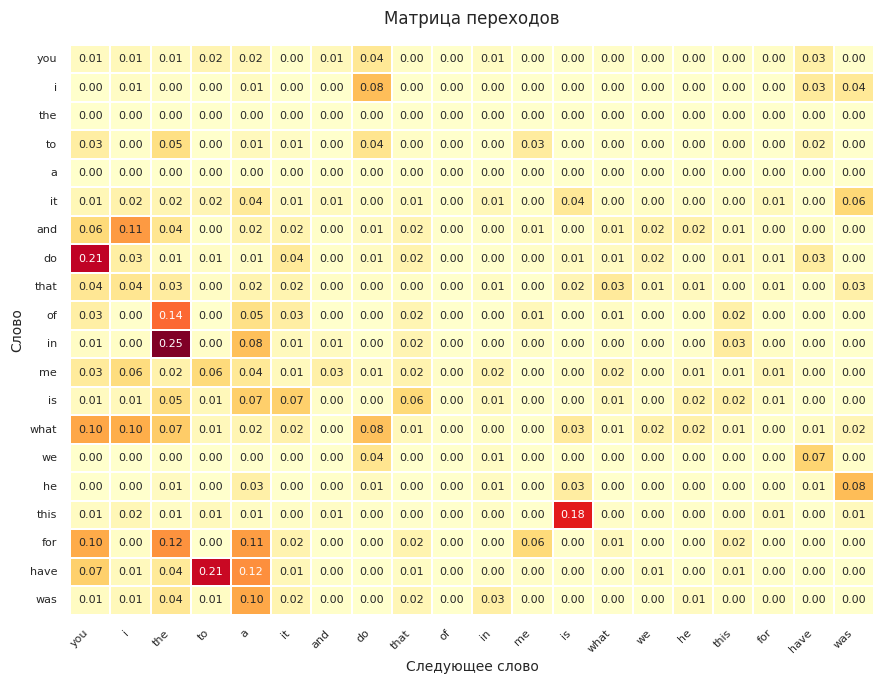

In [ ]:
top_bigrams = get_top_ngrams(dialogues, ngram_size=1, top_n=20)
visualize_transitions(model, top_bigrams, ngram_size=1, context_words=1)

Видим, что выделяются несколько конструкций, такие как `do you`, `in the`, `have to`.

Теперь попробуем сгенерировать несколько реплик.

In [ ]:
def generate_dialogue(
    model: Dict[str, Dict[str, float]],
    max_length: int = 15,
    n_gram: int = 2
) -> str:
    """
    Аргументы:
        model: Обученная n-граммная модель
            (ключи - префиксы, значения - распределения следующих слов)
        max_length: Максимальная длина генерируемого текста в словах
        n_gram: Порядок модели (2 для биграмм, 3 для триграмм и т.д.)

    Возвращает:
        Сгенерированную текстовую строку с заглавной буквой и случайным знаком пунктуации
    """
    # 1. Инициализация начального состояния
    prefix = ' '.join(['<start>'] * n_gram)  # Создаем начальный префикс (например, "<start> <start>" для биграмм)
    result = []

    for _ in range(max_length):
        # 2. Получаем возможные следующие слова и их вероятности для текущего префикса
        next_words = list(model[prefix].keys())
        probs = list(model[prefix].values())

        # Если для префикса нет продолжений
        if not next_words:
            break

        # 3. Выбор следующего слова согласно распределению вероятностей
        next_word = np.random.choice(next_words, p=probs)

        # 4. Проверка условия завершения генерации
        if next_word == '<end>':
            break

        # 5. Добавляем слово в результат и обновляем префикс
        result.append(next_word)
        # Сдвигаем окно контекста: сохраняем последние (n_gram-1) слов + новое слово
        prefix = ' '.join((prefix + ' ' + next_word).split()[-n_gram:])
    return ' '.join(result).capitalize()

Генерируем 5 примеров.

In [ ]:
print("Сгенерированные реплики:")
for _ in range(5):
    print(f"- {generate_dialogue(model, n_gram=1)}")

Сгенерированные реплики:
- He not a good evening
- What with me i going to say you got shade more seriously jump about the
- Bob like such transactions are you know what wrong anesthetic
- What did you to have family business you for you resent how many children and
- How to promise


#### 2.3 Биграммы ($n = 2$)

Попробуем предсказывать следующий токен по биграммам.

**Состояния:** Пары слов (биграммы)

**Матрица переходов:** Вероятности перехода между словами, зависящие от двух предыдущих слов:

$$\mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t, X_{t-1} = w_{t-1}, \ldots) = \mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t, X_{t-1} = w_{t-1}) $$

**Пример матрицы переходов**

| Предыдущее/Текущее | `<start>` | `я`   | `люблю` | `кошек` | `собак` | `<end>` |
|---------------------|---------|-----|-------|-------|-------|-------|
| `<start>`, `я`          | 0       | 0   | 1.0   | 0     | 0     | 0     |
| `я`, `люблю`            | 0       | 0   | 0     | 0.5   | 0.5   | 0     |
| `люблю`, `кошек`        | 0       | 0   | 0     | 0     | 0     | 1.0   |
| `люблю`, `собак`        | 0       | 0   | 0     | 0     | 0     | 1.0   |

В данной матрице:
- Строки – комбинации предыдущей биграммы, возможные состояния.
- Столбцы – варианты следующих слов.
- Размер: Если у вас $N$ уникальных слов в языке, тогда теоретически количество уникальных биграмм будет $N^2$, так что количество строк будет $N^2$, и количество столбцов будет равно количеству уникальных слов $N$. Однако на практике используются только те биграммы, которые находятся в ваших данных, так как не все комбинации встречаются.


In [ ]:
model = build_markov_model(dialogues, context_size=2)

Построение марковской модели: 100%|██████████| 194129/194129 [00:32<00:00, 6026.45it/s]


Посмотрим на наиболее вероятные варианты продолжения нескольких слов.

In [ ]:
show_top_next_words(model, ["it was", "this is", "<start> cat"])


Топ-10 после 'it was':
Слово           Вероятность
-------------------------
a               0.1252
the             0.0470
just            0.0416
my              0.0280
an              0.0274
<end>           0.0232
all             0.0229
like            0.0220
you             0.0205
so              0.0152

Топ-10 после 'this is':
Слово           Вероятность
-------------------------
a               0.1298
the             0.1085
my              0.0517
not             0.0355
your            0.0231
what            0.0226
all             0.0223
it              0.0193
going           0.0185
an              0.0172

Топ-10 после '<start> cat':
Слово           Вероятность
-------------------------
that            0.5000
you             0.5000


In [ ]:
print("Сгенерированные реплики:")
for _ in range(5):
    print(f"- {generate_dialogue(model, n_gram=2)}")

Сгенерированные реплики:
- You may do the right track
- Yes and do something with such a genius to look into my personality in a
- The traffic patterns and pretend to know a compound used as well as stupid as
- Then i u know it hurts be happy to be done
- They just make an ideal it may be a very good you got any there


Генерация стала немного более осмысленной, так как учтена большая связь между словами, но для того, чтобы все предложение имело смысл учета двух предыдущих токенов еще недостаточно.

#### 2.4 Предсказание для $n = 5$

Теперь увеличим длину последовательности, по которой будем предсказывать следующее слово до 5.

**Состояния:** Последовательности из пяти слов

**Матрица переходов:** Вероятности перехода между словами, зависящие от пяти предыдущих слов:
$$ \mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t, X_{t-1} = w_{t-1}, \ldots) = \mathsf{P}(X_{t+1} = w_{t+1} \mid X_t = w_t, X_{t-1} = w_{t-1}, X_{t-2} = w_{t-2}, X_{t-3} = w_{t-3}, X_{t-4} = w_{t-4}) $$



In [ ]:
model = build_markov_model(dialogues, context_size=5)

Построение марковской модели: 100%|██████████| 194129/194129 [00:37<00:00, 5129.06it/s]


Посмотрим на некоторые части матрицы переходов. Контекст больше, поэтому количество слов, которое может встретиться после данного, сокращается.

In [ ]:
show_top_next_words(model, ["<start> " + "it was the first", "<start> " * 2 + "in the beginning",
                    "<start> " * 3 + "are you"])


Топ-10 после '<start> it was the first':
Слово           Вероятность
-------------------------
time            1.0000

Топ-10 после '<start> <start> in the beginning':
Слово           Вероятность
-------------------------
there           0.5000
then            0.5000

Топ-10 после '<start> <start> <start> are you':
Слово           Вероятность
-------------------------
sure            0.1014
going           0.0912
kidding         0.0552
a               0.0428
crazy           0.0304
saying          0.0282
trying          0.0248
gon             0.0225
the             0.0214
in              0.0203


Посмотрим на примеры реплик, которые получается сгенерировать.

In [ ]:
print("Сгенерированные реплики:")
for _ in range(5):
    print(f"- {generate_dialogue(model, n_gram=5)}")

Сгенерированные реплики:
- Then how can it be chipped
- Paul where is he can you see him
- They not delivering i going to go pick up the pizza
- Sure i know maya real well
- Tomorrow the buyer is japanese his retirement a condition of the bonus


Связки между словами получились более осмысленными, но для генерации сложных или длинных текстов стоит брать другие модели.

---
В данном ноутбуке мы рассмотрели примеры работы с последовательными зависимыми данными. Одним из простых примеров зависимости в текстовых данных является грамматическая структура предложения. В большинстве языков предложение состоит из разных частей речи, которые следуют определенным правилам и порядку в предложении: часто после существительного часто следует глагол, а затем — объект.

Таким образом, понимание и использование таких грамматических и лексических зависимостей позволяет моделям генерировать текст, который больше соответствует естественному языку, с грамматически правильными и семантически осмысленными предложениями.


Эти методы хорошо иллюстрируют фундаментальные принципы работы с последовательными данными, но в реальной жизни зависимости могут иметь более сложный вид. Так, например, для генерации осмысленных текстов и решения более сложных задач требуются модели, которые могут учитывать более нетривиальные закономерности в данных и больший контекст.